<h1 style="text-align: center; vertical-align: middle;">Reinforcement learning for focusing and steering tasks</h1>
<h2 style="text-align: center; vertical-align: middle;">Use case: ARES linear accelerator at DESY</h2>

<h3 style="text-align: center; vertical-align: middle;">Implementation example for RL4AA'23 workshop</h3>

<p style="text-align: center">Jan Kaiser, Chenran Xu, Andrea Santamaria Garcia, Simon Hirländer</p>

<h2 style="color: #b51f2a">Today!</h2>

In this tutorial notebook we will implement all the basic components of a **Reinforcement Learning algorithm** to solve a problem in particle accelerators, focused on __reward definition__

- Part I: Introduction
- Part II: Algorithm implementation in Python
- Part III: Reward definition!
- Part IV: Training an RL agent

<div style="text-align: center; width:100%;">
    <h2>Part I: Introduction</h2>
</div>

<h2 style="color: #b51f2a"> ARES (Accelerator Research Experiment at SINBAD)</h2>

ARES is an S-band radio frequency linac at the DESY Hamburg site equipped with a photoinjector and two independently driven traveling wave accelerating structures. The main research focus is the generation and characterization of sub-femtosecond electron bunches at relativistic particle energy. The generation of short electron bunches is of high interest for radiation generation, i.e. by free electron lasers.

<img src="img/ARES_layout.png" style="width:100%; margin:auto;"/>

- **Final energy**: 100-155 MeV
- **Bunch charge**: 0.5-30 pC
- **Bunch length**: 0.2-10 fs
- **Pulse repetition rate**: 10-50 Hz

<h2 style="color: #b51f2a">The accelerator problem we want to solve</h2>

We would like to focus and center the electron beam on a diagnostic screen using corrector and quadrupole magnets

<img src="img/ares_magnets.png" style="width:70%; margin:auto;"/>

<h2 style="color: #b51f2a">Formulating the RL problem</h2>
<h3>Refresher from the lecture</h3>

We need to define:
- Actions
- Observations
- Reward
- Environment
- Agent
<img src="img/rl_problem_2.png" style="width:70%; margin:auto;"/>

<h2 style="color: #b51f2a">Formulating the RL problem</h2>
<h3>Overview of our study case</h3>
<img src="img/ares_rl_problem.png" style="width:70%; margin:auto;"/>

<h3 style="color:#038aa1;">Discussion</h3>
<p style="color:#038aa1;">$\implies$  Is the action space continuous or discrete? </p>
<p style="color:#038aa1;">$\implies$  Is the problem deterministic or stochastic?</p>

<h2 style="color: #b51f2a">Formulating the RL problem</h2>
<h3>Actions</h3>

<div class="row">
    <div class="column" style="width:60%;float:left">
        <p>In the ARES transverse tuning task we have 3 quadrupoles and 2 corrector magnets</p>
        <p> The actions are:
            <ul>
                <li><b>Quadrupole magnet strength</b> $k_{1,2,3}$ $[1/m^2]$</li>
                <li><b>Corrector deflection angle</b> $\theta_\mathrm{v, h}$ $[mrad]$ (vertical and horizontal)</li>
            </ul>
        </p>
        <p>In our control system we can set these derived values directly according the beam energy</p>
        <p>$\implies$ <code>actions</code> $=[k_{\mathrm{Q1}},k_{\mathrm{Q2}},\theta_\mathrm{CV},k_{\mathrm{Q3}},\theta_\mathrm{CH}]$</p>
            <p>is a 5-dimensional array</p>
    </div>
    <div class="column" style="width:40%;float:right">
        <img src="img/dipole.png" style="width:50%; margin:auto;"/>
        <img src="img/quads.png" style="width:35%; margin:auto;"/>
    </div>
</div>

<h2 style="color: #b51f2a">Formulating the RL problem</h2>
<h3>Observation / state</h3>

<div class="row">
    <div class="column" style="width:50%;float:left">
        <p>Observation is the information an agent receives about the current state of the environment</p>
        <p>It should provide enough information so that the agent can solve this problem.</p>
        <h3 style="color:#038aa1;">Discussion</h3>
        <p style="color:#038aa1;">$\implies$ What should be included in the <code>observation</code>?  </p>
        <p style="color:#038aa1;">$\implies$ What can be observed in simulation? </p>
        <p style="color:#038aa1;">$\implies$ What cannot be observed in real world? </p>
        <p style="color:#038aa1;">$\implies$ How does this relate to the environment? </p>
    </div>
    <div class="column" style="width:50%;float:right">
      <img src="img/screen_2.png" style="width:40%; margin:auto;"/>
      <p style="clear:both; font-size: small; text-align: center; margin-top:1em;">
          The screen is made from scintillating material and glows when hit by electrons</p>
      <img src="img/screen_1.png" style="width:40%; margin:auto;"/>
      <p style="clear:both; font-size: small; text-align: center; margin-top:1em;">The camera films the screen</p>
    </div>
</div>

<h2 style="color: #b51f2a">Formulating the RL problem</h2>
<h3> Our definition of observation</h3>

The `observation` for this task contains three parts:
- The __target beam__: the beam we want to achieve, our goal
  - as a 4-dimensional array $b^\mathrm{(t)}=[\mu_x^{(\mathrm{t})},\sigma_x^{(\mathrm{t})},\mu_y^{(\mathrm{t})},\sigma_y^{(\mathrm{t})}]$, where $\mu$ denotes the position on the screen, $\sigma$ denotes the beam size, and $t$ stands for "target".
- The __current beam__: the beam we currently have
    - $b^\mathrm{(c)}=[\mu_x^{(\mathrm{c})},\sigma_x^{(\mathrm{c})},\mu_y^{(\mathrm{c})},\sigma_y^{(\mathrm{c})}]$, where $c$ stands for "current"
- The __magnet strengths__ and __deflection angles__
    - $[k_{\mathrm{Q1}},k_{\mathrm{Q2}},\theta_\mathrm{CV},k_{\mathrm{Q3}},\theta_\mathrm{CH}]$

<h3 style="color:#038aa1;">Discussion</h3>
<p style="color:#038aa1;">$\implies$ Does this state definition fullfil the Markov property? (does the probability distribution for the next beam depend only on the present state? or is it affected by information about the past?)</p>

<h2 style="color: #b51f2a">Formulating the RL problem</h2>
<h3>Goal and reward: refresher from the lecture</h3>
<img src="img/rl_problem_1.png" width="70%"/>


<h2 style="color: #b51f2a">Formulating the RL problem</h2>
<h3>Goal and reward</h3>

Our goal is to steer and focus the beam to a required position and beam size

<h3 style="color:#038aa1;">Discussion</h3>
<p style="color:#038aa1;">$\implies$ How should we define our reward function? Give it a go!</p>
<p style="color:#038aa1;">$\implies$ We have a whole section dedicated to reward formulation later on</p>

<h2 style="color: #b51f2a">Formulating the RL problem</h2>
<h3>Agent / algorithm</h3>


<img src="img/algo_flow_dark.png"  style="width:60%; margin:auto;"/>
<p style="clear:both; font-size: small; text-align: center; margin-top:1em;">image from <a href="https://araffin.github.io/slides/rlvs-tips-tricks/#/16">RL Tips and Tricks - A. Raffin</a></p>

<h3 style="color:#038aa1;">Discussion</h3>
<p style="color:#038aa1;">$\implies$ What would you choose and why?</p>

<div style="text-align: center; width:100%;">
    <h2>Part II: Algorithm implementation in Python</h2>
</div>

<h2 style="color: #b51f2a">About libraries for RL</h2>

There are many libraries with already implemented RL algorithms, and frameworks to implement an environment to interact with. In this notebook we use:
- [Stable-Baselines3](https://stable-baselines3.readthedocs.io/) for the agents
- [OpenAI Gym](https://www.gymlibrary.dev/) for the environment
<img src="img/rl_libraries.png"  style="width:60%; margin:auto;"/>
<p style="clear:both; font-size: small; text-align: center; margin-top:1em;">More info <a href="https://neptune.ai/blog/the-best-tools-for-reinforcement-learning-in-python">here</a></p>

<h2 style="color: #b51f2a">Agent / algorithm</h2>

- As mentioned, we use the [Stable-Baselines3](https://stable-baselines3.readthedocs.io/) (SB3) package to implement the reinforcement learning algorithms.
- In this tutorial we focus on two examples: [PPO](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) (proximal policy optimization) and [TD3](https://stable-baselines3.readthedocs.io/en/master/modules/td3.html) (twin delayed DDPG)

<h2 style="color: #b51f2a">Environment</h2>

We take all the elements of the RL problem we defined previously and reprensent the tuning task as an [OpenAI Gym](https://www.gymlibrary.dev/) environment, which is a standard library for RL tasks.

A custom `gym.Env` would contain the following parts:

- __Initialization__: setup the environment, declares the allowed `observation_space` and `action_space`
- `reset` __method__: resets the environment for a new episode, returns 2-tuple `(observation, info)`
- `step` __method__: main logic of the environment. It takes an `action`, changes the environment to a new `state`, get new `observation`, compute the `reward`, and finally returns the 4-tuple `(observation, reward, done, info)` 
    - `done` checks if the current episode should be terminated (reached goal reached, or exceeded some thresholds)
- `render` __method__: to visualize the environment (a video,or just some plots)

<h2 style="color: #b51f2a">An overview of this RL project</h2>
<img src="img/ares_ea_rl_technical_setup.png"  style="width:100%; margin:auto;"/>

<h2 style="color: #b51f2a">Code directory structure</h2>

We list the most relevant parts of the project structure below:

- `utils/train.py` contains the gym environments and the training script
    - `ARESEA` implements the ARES Experimental Area transverse tuning task as a `gym.Env`. It contains the basic logic, such as definition of observation space, action space, and reward. How an action is taken is implemented in child classes with specific backends. 
    - `ARESEACheetah` is derived from the base class `ARESEA`, where it uses `cheetah` simulation as a backend.
    - `make_env` Initializes a `ARESEA` envrionment, and wraps it with required [gym.wrappers](https://www.gymlibrary.dev/api/wrappers/) with convenient features (e.g. monitoring the progress, end episode when time_limit is reached, rescales the action, normalize the observation, ...)
    - `train` convenient function for training the RL agent. It calls `make_env`, setup the RL algorithm, starts training, and saves the results in `utils/recordings`, `utils/monitors` and `utils/models`.
- `utils/helpers.py` contains some utility functions
    - `evaluate_ares_ea_agent` Takes a trained agent and evaluates its performance using different metrics.
    - `plot_ares_ea_training_history` shows the progress during training

<h2 style="color: #b51f2a">What is Cheetah?</h2>

- RL algorithms require a large number of samples to learn ($10^5-10^9$), and getting those samples in the real  accelerator is often too costly. 
    - This is why a common approach is to train the agent in simulation, and then deploy it in the real machine
- In our case we would train with optics simulation codes for accelerators, such as <a href="https://github.com/ocelot-collab/ocelot">OCELOT </a>
    - These codes were developed to help the design phases of accelerators, but not to generate training data, making their computing time too high for RL.
- __Cheetah__ is a tensorized approach for transfer matrix tracking, which saves computation time and overhead compared to OCELOT

More information <a href="https://accelconf.web.cern.ch/ipac2022/papers/wepoms036.pdf">here</a> and <a href="https://github.com/desy-ml/cheetah">here</a>

In [1]:
from time import sleep

import matplotlib.pyplot as plt
import names
import numpy as np
from gym.wrappers import RescaleAction
from IPython.display import clear_output, display
from stable_baselines3 import PPO

from utils.helpers import (
    evaluate_ares_ea_agent,
    make_ares_ea_training_videos,
    plot_ares_ea_training_history,
    show_video,
)
from utils.preamble import *
from utils.train import ARESEACheetah, make_env, read_from_yaml
from utils.train import train as train_ares_ea
from utils.utils import NotVecNormalize


<h2 style="color: #b51f2a">The ARESEA (ARES Experimental Area) Environment</h2>

- We formulated the ARESEA task as a [OpenAI Gym](https://github.com/openai/gym) environment, which allows our algorithm to easily interface with both the simulation and real machine backends as shown before.
- In this part, you will get familiar with the environment for the beam focusing and positioning at ARES accelerator.

Some methods:
- `reset`: in both real and simulation cases: resets the magnets to initial values. In simulation, regenerate incoming beam, (optionally) resets the magnet misalignments.
- `step`: set magnets to new settings. Observe the beam (run a simulation or observe screen image in real-world).

Now let's create the environment:

In [2]:
# Create the environment
env = ARESEACheetah()
env.target_beam_mode = "constant"


<h3 style="color:#038aa1;">Set a target beam you want to achieve</h3>
<p style="color:#038aa1;">$\implies$ Let's define the position $(\mu_x, \mu_y)$ and size $(\sigma_x, \sigma_y)$ of the beam on the screen</p>
<p style="color:#038aa1;">$\implies$ Modify the <code>target_beam</code> list below, where the order of the arguments is $[\mu_x,\sigma_x,\mu_y,\sigma_y]$</p>
<p style="color:#038aa1;">$\implies$ Take into account the dimensions of the screen ($\pm$ 2e-3 m)</p>
<p style="color:#038aa1;">$\implies$ The target beam will be represented by a blue circle on the screen</p>

In [3]:
target_beam = np.array([1e-3, 2e-4, 1e-3, 2e-4])  # Change it


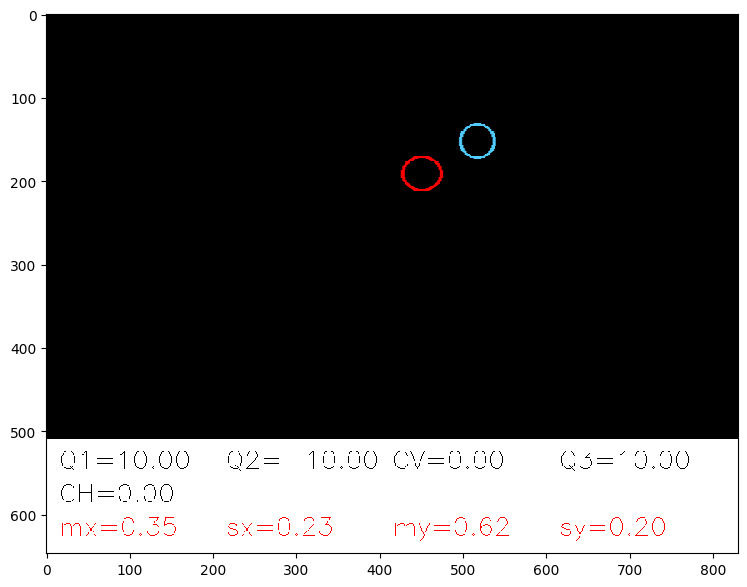

In [4]:
env.target_beam_values = target_beam
env.reset()  ##
plt.imshow(env.render(mode="rgb_array"))  # Plot the screen image


<h3 style="color:#038aa1;">Get familiar with the Gym environment</h3>
<p style="color:#038aa1;">$\implies$ Change the magnet values, i.e. the actions</p>
<p style="color:#038aa1;">$\implies$ The actions are normalized to 1, so valid values are in the [0, 1] interval</p>
<p style="color:#038aa1;">$\implies$ The values of the <code>action</code> list in the cell below follows this magnet order: [Q1, Q2, CV, Q3, CH]</p>
<p style="color:#038aa1;">$\implies$ Observe the plot below, what beam does that magnet configuration yield? can you center and focus the beam by hand?</p>


In [5]:
action = np.array([1, 0.5, 0.5, 1, 0.6])  # put your action here


Perform one step: update the env, observe new beam!

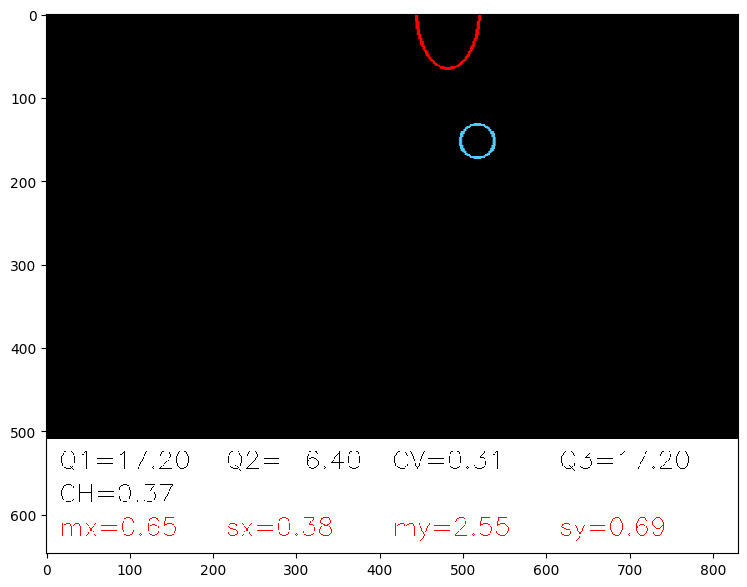

In [6]:
env = RescaleAction(env, -1, 1)  # rescales the action to the interval [-1, 1]
env.reset()
env.step(action)
plt.imshow(env.render(mode="rgb_array"))


<p style="color:#038aa1;">$\implies$ Observe the plot above, what beam does that magnet configuration yield? can you center and focus the beam by hand?</p>


- Let's now use the environment in a loop, and perform 10 steps
- The function below will linearly vary the value of the vertical corrector

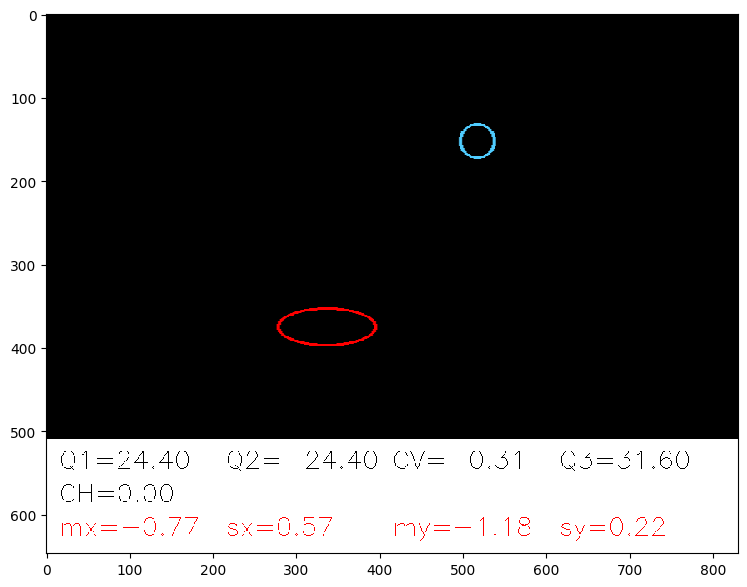

In [7]:
env.reset()
steps = 10


def change_vertical_corrector(q1, q2, cv, q3, ch, steps, i):
    action = np.array([q1, q2, cv + 1 / steps * i, q3, ch])
    return action


fig, ax = plt.subplots(1)
for i in range(steps):
    action = change_vertical_corrector(0.2, -0.2, -0.5, 0.3, 0, steps, i)
    env.step(action)
    img = env.render(mode="rgb_array")
    ax.imshow(img)
    display(fig)
    clear_output(wait=True)
    sleep(0.5)


<div style="text-align: center; width:100%;">
    <h2>Part III: Reward definition!</h2>
</div>

- In the following, we reduce our problem to only __focusing of the beam__, and actuators to only __3 quadrupole magnets__ 
    - In this way, we can train a RL agent with fewer steps

Training a good agent revolves primarily around finding the right setup for the environment and the correct reward function. In order to iterate over and compare many different options, our training function takes a dictionary called `config`. The dictionary keys or "configurations" are explained below

<h2 style="color: #b51f2a">Configurations</h2>

In the following, we use a `config` dictionary to set up the training. This allows us to easily switch between different training conditions. Below we show some selected configurations that have the most influence on training results, the parameters can mostly be divided into two parts.

<h2 style="color: #b51f2a">Configurations</h2>

<h3>Environment configurations</h3>

- `action_mode` Set directly the magnet strength or set a delta action. You may set this to `"direct"` or `"delta"`. You should find that "delta" trains faster. Setting "delta" is also crucial in running the agent on the real accelerator.
- `reward_mode`: How the reward is calculated. Can be set to `negative_objective`, `objective_improvement`, or `sum_of_pixels`.
- `time_reward`: Whether the agent will be penalized for making another step, this is intended to make the tuning faster.
- `rescale_action`: Takes the limits of the magnet settings and scale them into the following range.

Termination conditions:
- `abort_if_off_screen` If this property is set to True, episodes are aborted when the beam is no longer on the screen.
- `time_limit`: Number of interactions the agent gets to tune the magnets within one episode.
- `target_sigma_x_threshold`, `target_sigma_y_threshold`: Thresholds for beam parameters. If all beam parameters are within the threshold from their target, episodes will end and the agent will stop optimising.


<h3 style="color:#038aa1;">Question</h3>
<p style="color:#038aa1;">$\implies$ What does the existence of termination conditions says about the nature of the problem? is it episodic or continuous?</p>

<h2 style="color: #b51f2a">What could go wrong?</h2>

Let's load some pre-trained models using different combinations of the `config` dictionary and using different reward definitions

<h2 style="color: #b51f2a">Pre-trained Agent 1: "Gary Buchwald"</h2>

<h3>Relevant <code>config</code> parameters</h3>

- **`"abort_if_off_screen": True`**
- **`"reward_mode": "objective_improvement"`**
- `"target_sigma_x_threshold": None`
- `"target_sigma_y_threshold": None`
- **`"time_reward": -1.0`**
- `"action_mode": "delta"`

<h3>Reward = <code>objective_improvement</code></h3>
Difference of the objective:

$$ r_\mathrm{obj-improvement} = (\mathrm{obj}_{j} - \mathrm{obj}_{j-1} ) / \mathrm{obj}_0 $$
$$ obj = \sum_{i}|b_i^\mathrm{(c)} - b_i^\mathrm{(t)}|$$

where $j$ is the index of the current time step.

<h3 style="color:#038aa1;">Question</h3>
<p style="color:#038aa1;">$\implies$ What do you expect to happen, why?</p>

In [8]:
agent_name = "Gary Buchwald"  # names are randomly generated in training

loaded_model = PPO.load(f"utils/models/{agent_name}/model")
loaded_config = read_from_yaml(f"utils/models/{agent_name}/config")

env = make_env(loaded_config, record_video=False)
env = NotVecNormalize(env, f"utils/models/{agent_name}/normalizer")

done = False
observation = env.reset()
env.render()
while not done:
    action, _ = loaded_model.predict(observation)
    observation, reward, done, info = env.step(action)
    env.render()
    sleep(0.5)


In [9]:
env.close()
# destroy the window


<h2 style="color: #b51f2a">Pre-trained Agent 2: "David Archibald"</h2>

<h3>Relevant <code>config</code> parameters</h3>

- `"abort_if_off_screen": False`
- **`"reward_mode": "sum_of_pixels"`**
- `"target_sigma_x_threshold": None`
- `"target_sigma_y_threshold": None`
- `"time_reward": 0.0`
- `"action_mode": "delta"`

<h3>Reward = <code>sum_of_pixels</code> (focusing-only)</h3>
    
$$r_\mathrm{sum-pixel} = - \sum_\text{all pixels} \text{screen-image}$$

<h3 style="color:#038aa1;">Question</h3>
<p style="color:#038aa1;">$\implies$ What do you expect to happen, why?</p>

In [10]:
agent_name = "David Archibald"  # names are randomly generated in training

loaded_model = PPO.load(f"utils/models/{agent_name}/model")
loaded_config = read_from_yaml(f"utils/models/{agent_name}/config")

env = make_env(loaded_config, record_video=False)
env = NotVecNormalize(env, f"utils/models/{agent_name}/normalizer")

done = False
observation = env.reset()
env.render()
while not done:
    action, _ = loaded_model.predict(observation)
    observation, reward, done, info = env.step(action)
    env.render()
    sleep(0.5)


In [11]:
env.close()
# destroy the window


<h2 style="color: #b51f2a">Pre-trained Agent 3: "Bertha Sparkman"</h2>

<h3>Relevant <code>config</code> parameters</h3>

- `"abort_if_off_screen": False`
- **`"reward_mode": "objective_improvement"`**
- `"target_sigma_x_threshold": None`
- `"target_sigma_y_threshold": None`
- `"time_reward": 0.0`
- **`"action_mode": "direct"`**

<h3>Reward = <code>objective_improvement</code></h3>
Difference of the objective:

$$ r_\mathrm{obj-improvement} = (\mathrm{obj}_{j} - \mathrm{obj}_{j-1} ) / \mathrm{obj}_0 $$
$$ obj = \sum_{i}|b_i^\mathrm{(c)} - b_i^\mathrm{(t)}|$$

where $j$ is the index of the current time step.

<h3 style="color:#038aa1;">Question</h3>
<p style="color:#038aa1;">$\implies$ What do you expect to happen?</p>
<p style="color:#038aa1;">$\implies$ What is the difference between Agent 1: "Gary Buchwald" and this agent?</p>

In [12]:
agent_name = "Bertha Sparkman"  # names are randomly generated in training

loaded_model = PPO.load(f"utils/models/{agent_name}/model")
loaded_config = read_from_yaml(f"utils/models/{agent_name}/config")

env = make_env(loaded_config, record_video=False)
env = NotVecNormalize(env, f"utils/models/{agent_name}/normalizer")

done = False
observation = env.reset()
env.render()
while not done:
    action, _ = loaded_model.predict(observation)
    observation, reward, done, info = env.step(action)
    env.render()
    sleep(0.5)


In [13]:
env.close()
# destroy the window


<h2 style="color: #b51f2a">Pre-trained Agent 4: "Betty Gordon"</h2>

<h3>Relevant <code>config</code> parameters</h3>

- `"abort_if_off_screen": False`
- **`"reward_mode": "objective_improvement"`**
- `"target_sigma_x_threshold": None`
- `"target_sigma_y_threshold": None`
- `"time_reward": 0.0`
- `"action_mode": "delta"`

<h3>Reward = <code>objective_improvement</code></h3>
Difference of the objective:

$$ r_\mathrm{obj-improvement} = (\mathrm{obj}_{j} - \mathrm{obj}_{j-1} ) / \mathrm{obj}_0 $$
$$ obj = \sum_{i}|b_i^\mathrm{(c)} - b_i^\mathrm{(t)}|$$

where $j$ is the index of the current time step.

<h3 style="color:#038aa1;">Question</h3>
<p style="color:#038aa1;">$\implies$ What do you expect to happen?</p>
<p style="color:#038aa1;">$\implies$ What is the difference between Agent 1: "Gary Buchwald",  Agent 3: "Bertha Sparkman", and this agent?</p>

In [14]:
agent_name = "Betty Gordon"  # names are randomly generated in training

loaded_model = PPO.load(f"utils/models/{agent_name}/model")
loaded_config = read_from_yaml(f"utils/models/{agent_name}/config")

env = make_env(loaded_config, record_video=False)
env = NotVecNormalize(env, f"utils/models/{agent_name}/normalizer")

done = False
observation = env.reset()
env.render()
while not done:
    action, _ = loaded_model.predict(observation)
    observation, reward, done, info = env.step(action)
    env.render()
    sleep(0.5)


In [15]:
env.close()
# destroy the window


<h2 style="color: #b51f2a">Pre-trained Agent 5: "Sean Kelley"</h2>

<h3>Relevant <code>config</code> parameters</h3>

- `"abort_if_off_screen": False`
- `"reward_mode": "negative_objective"`
- `"target_sigma_x_threshold": None`
- `"target_sigma_y_threshold": None`
- `"time_reward": 0.0`
- `"action_mode": "delta"`

<h3>Reward = <code>negative_objective"</code></h3>
$$ \mathrm{obj} = \sum_{i}|b_i^\mathrm{(c)} - b_i^\mathrm{(t)}|$$
$$ r_\mathrm{neg-obj} = -1 * \mathrm{obj} / \mathrm{obj}_0 $$

where $b = [\mu_x,\sigma_x,\mu_y,\sigma_y]$, $b^\mathrm{(c)}$ is the current beam, and $b^\mathrm{(t)}$ is the target beam. $\mathrm{obj}_0$ is the initial objective after `reset`.

<h3 style="color:#038aa1;">Question</h3>
<p style="color:#038aa1;">$\implies$ What do you expect to happen, why?</p>

In [16]:
agent_name = "Sean Kelley"  # names are randomly generated in training

loaded_model = PPO.load(f"utils/models/{agent_name}/model")
loaded_config = read_from_yaml(f"utils/models/{agent_name}/config")

env = make_env(loaded_config, record_video=False)
env = NotVecNormalize(env, f"utils/models/{agent_name}/normalizer")

done = False
observation = env.reset()
env.render()
while not done:
    action, _ = loaded_model.predict(observation)
    observation, reward, done, info = env.step(action)
    env.render()
    sleep(0.5)


In [17]:
env.close()  # destroy the window


<div style="text-align: center; width:100%;">
    <h2>Part IV: Training an RL agent</h2>
</div>

<h2 style="color: #b51f2a">What is inside an actor-critic agent like PPO? </h2>

- An `actor model`, often a neural network, takes the `observation` of the current `state` and predicts an `action` to be taken (forward pass)
    - In the ARES case, it observes the accelerator and predicts the magnet settings
- A `critic model`, also a neural network, takes the `observation` of the current `state` and predicts the value function of the state (and evaluates how good is the action taken by the `actor model`)

<h2 style="color: #b51f2a">What actually happens when you train a PPO agent? (simplified version) </h2>
<h3>Step 1: collect samples</h3>

- `n_samples = n_steps * n_envs` is the total number of samples, or interactions with the environment in one `epoch` (more on what that means later)
    - One sample is collected at each step
    - We can initialize `n_envs` parallel environments, in which the agent will take `n_steps`
    - The total number of samples then has to account for the samples gathered in all environments

At each step:
- The agent will take actions according to the current `actor model` prediction (forward pass of the model NN)
- The `critic model` will predict the value functions of the states during the episode (forward pass of the model NN)

The samples (actions, rewards,...) from all environments are stored in a `buffer`, where `buffer_size = n_samples`

<h2 style="color: #b51f2a">What actually happens when you train a PPO agent? (simplified version) </h2>

<h3>Step 2: update the models (weights of NNs)</h3>

After performing `n_steps` in a particular environment (and therefore gathering `n_steps` number of samples per environment), it's time to update the actor and critic models (backpropagation of the NNs). Let's consider only 1 environment now for simplicity.

- One can split the `n_samples` in mini-batches of a certain `batch_size`
    - This means that the model will be completely updated (i.e. has seen all the samples) after `n_samples_tot`/`batch_size` number of backpropagations
    - Once the model is updated, it can be trained again on the same samples a certain number of `n_epochs` (number of iterations on the training set)
    - This process can be repeated a certain number of `epochs` (yes...)
    - The total number of samples across the epochs is `total_timesteps`, where
        - `total_timesteps = n_steps * n_envs * n_epochs = n_samples * n_epoch`

<h2 style="color: #b51f2a">What actually happens when you train a PPO agent? (simplified version) </h2>
<img src="img/rl_training.png"  style="width:70%; margin:auto;"/>

<h3 style="color:#038aa1;">Question</h3>
<p style="color:#038aa1;">$\implies$ What the advantage of having a buffer?</p>

<h2 style="color: #b51f2a">What actually happens when you train a PPO agent? (simplified version) </h2>

<h3>Example</h3>

Let's consider the following training parameters:
- `n_steps` = 100
- `n_envs` = 2
- `batch_size` = 50
- `n_epochs` = 3
- `epochs` = 2

<h3 style="color:#038aa1;">Question</h3>
<p style="color:#038aa1;">$\implies$ What is <code>total_timesteps</code>? 400</p>
<p style="color:#038aa1;">$\implies$ What is the total number of batches <code>n_batch</code> in 1 epoch? 4</p>
<p style="color:#038aa1;">$\implies$ What is the total number of model updates? 24</p>

<h2 style="color: #b51f2a">Training time!</h2>

Now, set the config below and train your first reinforcement learning agent!

Apart from the reward definition, time_reward, etc. that we discussed before. Below are some other configurations that you can change:

- `net_arch`: architecture of the policy network (# of neurons in each layer)
- `gamma`: Discount factor of the RL problem. Set lower to make rewards now more important than rewards later (usually above 0.9)
- `normalize_observation`: Normalize observations throughout training by fitting a running mean and standard deviation of them
- `normalize_reward`: Normalize rewards throughout training by fitting a running mean and standard deviation of them

In [18]:
# Feel free to change some of the configurations here.
config = {
    "n_envs": 40,
    "n_steps": 50,
    "batch_size": 100,
    "n_epochs": 10,
    "total_timesteps": 200_000,
    "abort_if_off_screen": False,
    "action_mode": "delta",
    "gamma": 0.99,
    "frame_stack": None,
    "net_arch": [64, 64],
    "normalize_observation": True,
    "normalize_reward": True,
    "rescale_action": (-3, 3),
    "reward_mode": "negative_objective",
    "run_name": names.get_full_name(),
    "target_sigma_x_threshold": None,
    "target_sigma_y_threshold": None,
    "threshold_hold": 5,
    "time_limit": 25,
    "time_reward": -0.0,
}


<h3 style="color:#038aa1;">Questions</h3>
<p style="color:#038aa1;">Looking at the <code>config</code> dictionary in the cell above:</p>
<p style="color:#038aa1;">$\implies$ How many epochs does it correspond to? 100</p>
<p style="color:#038aa1;">$\implies$ How many model updates (backpropagation) would you be doing in total? 8e4</p>

You will train the agent by executing the cell below:

In [19]:
# Toggle comment to re-run the training (can take very long)
%time train_ares_ea(config)

==> Training agent "Jennifer Thomas"
Eval num_timesteps=20000, episode_reward=-12.58 +/- 1.31
Episode length: 25.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=-7.28 +/- 0.91
Episode length: 25.00 +/- 0.00
New best mean reward!
Eval num_timesteps=60000, episode_reward=-5.21 +/- 0.52
Episode length: 25.00 +/- 0.00
New best mean reward!
Eval num_timesteps=80000, episode_reward=-4.25 +/- 0.53
Episode length: 25.00 +/- 0.00
New best mean reward!
Eval num_timesteps=100000, episode_reward=-5.65 +/- 1.93
Episode length: 25.00 +/- 0.00
Eval num_timesteps=120000, episode_reward=-5.42 +/- 2.24
Episode length: 25.00 +/- 0.00
Eval num_timesteps=140000, episode_reward=-5.38 +/- 1.30
Episode length: 25.00 +/- 0.00
Eval num_timesteps=160000, episode_reward=-4.47 +/- 0.37
Episode length: 25.00 +/- 0.00
Eval num_timesteps=180000, episode_reward=-5.17 +/- 0.64
Episode length: 25.00 +/- 0.00
Eval num_timesteps=200000, episode_reward=-4.76 +/- 0.74
Episode length: 25.00 +/- 0.0

As before we can look at the training metrics and check out videos taken at different stages of the training.

Comment out the following line and set `agent_under_investigation` to the name of your agent, to check its training history.

In [22]:
agent_under_investigation = config["run_name"]
# agent_under_investigation = "Donna Brown"


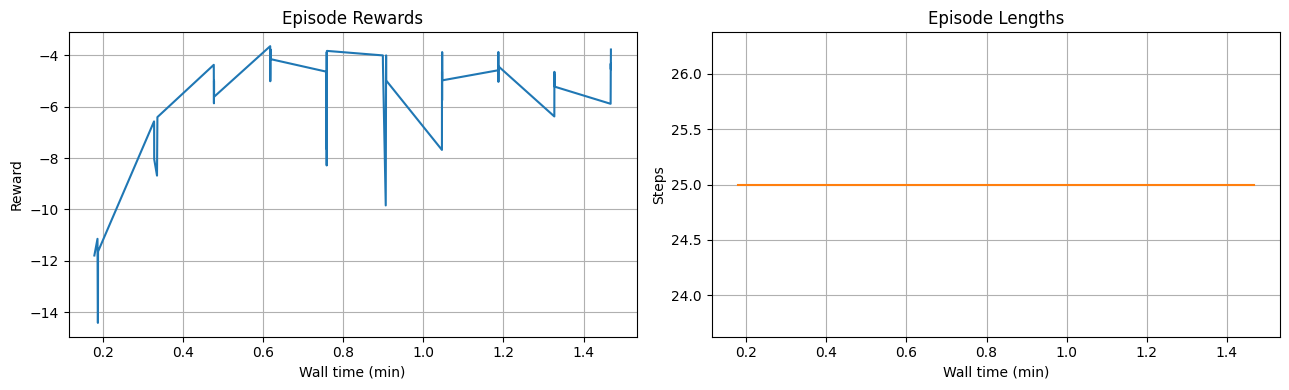

In [23]:
# Training curves from this training
# Change `config["run_name"` to `"ml_worksop` to see curves from example training.
plot_ares_ea_training_history(agent_under_investigation)


To look at videos of the agent during training:
1. find the first output line of the training cell. Your agent should have a name (e.g. *Fred Rogers*). 
2. Find the subdirectory `utils/recordings/`. 
3. There should be a directory for the name of your agent with video files in it. The `ml_workshop` directory contains videos from an example training.

Run the following cell to evaluate your agent. This is the mean deviation of the beam parameters from the target. Lower results are better.

If you are training agents that include the dipoles, set the functions argument `include_position=True`.

Evaluation results (2000 evaluations)
----------------------------------------
==> Mean MAE = 5.02380692053066e-05
==> RMSE = 6.899891515236461e-05
==> Mean no. of steps = 25.0


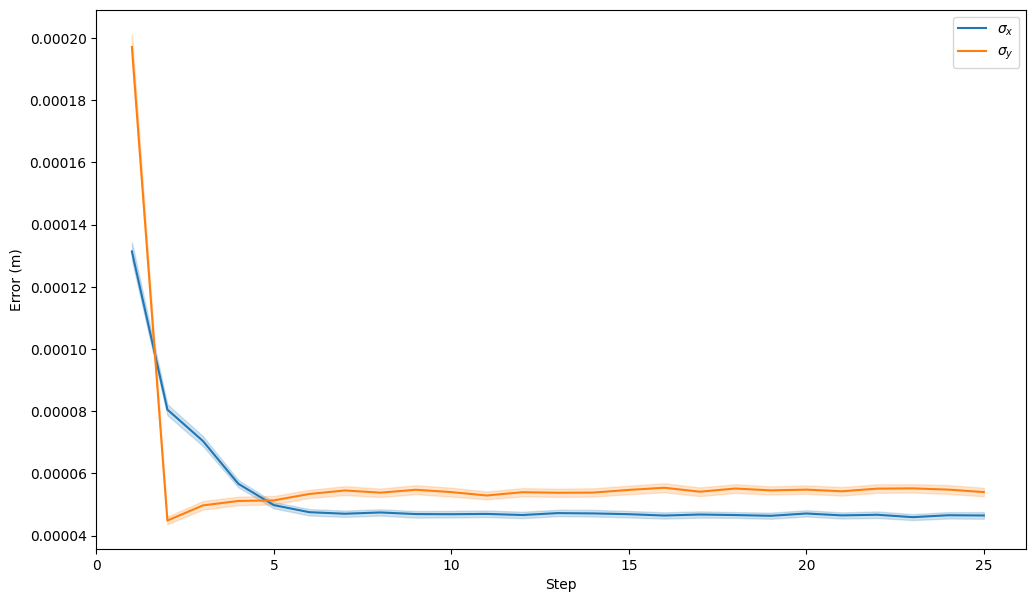

In [24]:
evaluate_ares_ea_agent(agent_under_investigation, include_position=False, n=2000)


We can also test the trained agent on a simulation.

If you want to see an example agent instead of the one you just trained, set `agent_name="ml_workshop"`.

In [25]:
# Run final agent
agent_name = agent_under_investigation

loaded_model = PPO.load(f"utils/models/{agent_name}/model")
loaded_config = read_from_yaml(f"utils/models/{agent_name}/config")

env = make_env(loaded_config, record_video=True)
env = NotVecNormalize(env, f"utils/models/{agent_name}/normalizer")

done = False
observation = env.reset()
while not done:
    action, _ = loaded_model.predict(observation)
    observation, reward, done, info = env.step(action)
env.close()


In [26]:
show_video(f"utils/recordings/{agent_under_investigation}/rl-video-episode-0.mp4")


### Running in the real world

Below you can see one of our final trained agents optimising position and focus of the beam on the real ARES accelerator.

Keep in mind that this agent has never seen the real accelerator before. All it has ever seen is a very simple linear beam dynamics simulation. Despite that it performs well on the real accelerator where all kinds of other effects come into the mix.

Note that this does not happen by itself and is the result of various careful decisions when designing the traiing setup.

Once trained, the agent is, however, trivial to use and requires no futher tuning or knowledge of RL.

In [27]:
# Show polished donkey running (on real accelerator)
show_video("utils/real_world_episode_recording.mp4")


## Further Resources

### Getting started in RL
 - [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/index.html) - Very understandable explainations on RL and the most popular algorithms acompanied by easy-to-read Python implementations.
 - [Reinforcement Learning with Stable Baselines 3](https://youtube.com/playlist?list=PLQVvvaa0QuDf0O2DWwLZBfJeYY-JOeZB1) - YouTube playlist giving a good introduction on RL using Stable Baselines3.
 - [Build a Doom AI Model with Python](https://youtu.be/eBCU-tqLGfQ) - Detailed 3h tutorial of applying RL using *DOOM* as an example.
 - [An introduction to Reinforcement Learning](https://youtu.be/JgvyzIkgxF0) - Brief introdution to RL.
 - [An introduction to Policy Gradient methods - Deep Reinforcement Learning](https://www.youtube.com/watch?v=5P7I-xPq8u8) - Brief introduction to PPO.

## Further Resources

### Papers

 - [Learning-based optimisation of particle accelerators under partial observability without real-world training](https://proceedings.mlr.press/v162/kaiser22a.html) - Tuning of electron beam properties on a diagnostic screen using RL.
 - [Sample-efficient reinforcement learning for CERN accelerator control](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.23.124801) - Beam trajectory steering using RL with a focus on sample-efficient training.
 - [Autonomous control of a particle accelerator using deep reinforcement learning](https://arxiv.org/abs/2010.08141) - Beam transport through a drift tube linac using RL.
 - [Basic reinforcement learning techniques to control the intensity of a seeded free-electron laser](https://www.mdpi.com/2079-9292/9/5/781/htm) - RL-based laser alignment and drift recovery.
 - [Real-time artificial intelligence for accelerator control: A study at the Fermilab Booster](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.24.104601) - Regulation of a gradient magnet power supply using RL and real-time implementation of the trained agent using field-programmable gate arrays (FPGAs).
 - [Magnetic control of tokamak plasmas through deep reinforcement learning](https://www.nature.com/articles/s41586-021-04301-9) - Landmark paper on RL for controling a real-world physical system (plasma in a tokamak fusion reactor).

## Further Resources

### Literature
 
 - [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) - Standard text book on RL.

### Packages
 - [Gym](https://www.gymlibrary.ml) - Defacto standard for implementing custom environments. Also provides a library of RL tasks widely used for benchmarking.
 - [Stable Baslines3](https://github.com/DLR-RM/stable-baselines3) - Provides reliable, benchmarked and easy-to-use implementations of the most important RL algorithms.
 - [Ray RLlib](https://docs.ray.io/en/latest/rllib/index.html) - Part of the *Ray* Python package providing implementations of various RL algorithms with a focus on distributed training.